# Mod 4 Project - Time Series Predictions


## Import Libraries and initial settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
# import folium
# from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Define Pandas display options for inspection 
# Set max rows to display to 2000
pd.set_option('display.max_rows', 2000)
# Set max columns to display to 500
pd.set_option('display.max_columns', 500)

## User defined functions

In [ ]:
# Reshape data from wide to long
def melt_data(df):
    # Use melt function to reshape with date as index, identifier variables set as id_vars
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    # Set time to datetime format to facilitate timeseries analysis
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    # Return reshaped dataset with timeseries as index value, and mean house price
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [3]:
# Load the dataset
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [4]:
#Check the number of columns in dataframe
len(df.columns)

272

In [5]:
#Check for missing values
cols = list(df.columns[7:])
df['NumberMissingValues'] = df[cols].isna().sum(axis=1)
df['NumberMissingValues'].value_counts()

0      13684
167      230
87       118
111       78
117       56
219       56
201       55
213       53
105       52
207       42
171       41
177       33
93        31
123       27
189       27
183       24
99        21
129       20
195       18
107       13
153       11
147        9
159        7
135        7
141        6
21         2
15         1
165        1
Name: NumberMissingValues, dtype: int64

In [ ]:
#Keep only rows of data with less than 24 months of data missing

# Create dataframe with all observations with more than 24 missing values
missingvalues = df[df['NumberMissingValues']>24].sort_values(['NumberMissingValues'], ascending=False)
# Identify the index numbers for all observations with more than 24 missing values
missingobs = missingvalues.index
# Drop missing values if more than 2 years' worth observations are missing
df.drop(index=missingobs, inplace=True)

In [ ]:
df[df['NumberMissingValues']>0]

In [ ]:
#Use backfilling to fill missing values for zipcodes
idx = [9906,11332,13504]
value = [95900.0, 85000.0, 103500.0]

for i in range(0,len(idx)):
    for j in range(0, len(cols)):
        if np.isnan(df.loc[idx[i], cols[j]]) == True:
            df.loc[idx[i], cols[j]] = value[i]

In [ ]:
#Visualize -- from notebook

In [ ]:
# Create dataframes which groups mean house price values by state
state = df.groupby(['State']).mean()
# Drop the columns which are surplus to requirement
state.drop(['RegionID', 'RegionName', 'SizeRank','NumberMissingValues'], axis=1, inplace=True)
# Reset the index
state.reset_index(inplace=True)
# Compute % growth across the two specified periods
state['Growth 2008 to 2018'] = ((state['2018-04'] - state['2008-01'])/state['2008-01'])*100
state['Growth 1998 to 2008'] = ((state['2008-01'] - state['1998-01'])/state['1998-01'])*100

In [ ]:
state.head()

In [ ]:
#Copy working df and drop unnecessary columns
dfzipgrowth = df.copy()
dfzipgrowth.drop(['RegionID', 'SizeRank','NumberMissingValues'], axis=1, inplace=True)

In [ ]:
# Compute % growth across the 5-year periods
dfzipgrowth['Growth 1998 to 2001'] = ((dfzipgrowth['2001-01'] - dfzipgrowth['1998-01'])/dfzipgrowth['1998-01'])*100
dfzipgrowth['Growth 1998 to 2001'] = ((dfzipgrowth['2001-01'] - dfzipgrowth['1998-01'])/dfzipgrowth['1998-01'])*100

Study Arkansas Washigton and Benton County

In [188]:
#Select State of AR only
dfAR = df.loc[df['State'] == 'AR']

In [189]:
#Select Washington and Benton Countys from AR
dfARCounty = dfAR.loc[dfAR['CountyName'].isin(['Washington', 'Benton'])]

In [101]:
#Check the number of NAs per zipcode
cols = list(dfARCounty.columns[7:])
dfARCounty['NumberMissingValues'] = dfARCounty[cols].isna().sum(axis=1)
dfARCounty['NumberMissingValues'].value_counts()

0      19
219     1
87      1
Name: NumberMissingValues, dtype: int64

In [102]:
dfARCounty[dfARCounty['NumberMissingValues']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumberMissingValues
868,89749,72764,Springdale,AR,Fayetteville,Washington,869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104900.0,106600.0,108400.0,110200.0,111600.0,112200.0,113100.0,114800.0,117000.0,119200.0,121400.0,123600.0,125600.0,127300.0,128400.0,129200.0,129500.0,129200.0,129400.0,130600.0,132100.0,133300.0,134200.0,134900.0,135600.0,136400.0,137200.0,138200.0,138900.0,139300.0,140200.0,141900.0,144100.0,145900.0,147200.0,147800.0,148200.0,148300.0,148400.0,148500.0,148400.0,148000.0,147800.0,147700.0,148000.0,148200.0,148000.0,147500.0,147000.0,146500.0,146200.0,145800.0,145200.0,144700.0,144200.0,143400.0,142600.0,141900.0,140800.0,139300.0,137900.0,136600.0,135300.0,134000.0,132700.0,131400.0,130200.0,128800.0,127700.0,126700.0,125400.0,123900.0,122600.0,121500.0,120600.0,119600.0,118900.0,118000.0,117600.0,117900.0,116800.0,114200.0,112600.0,112300.0,111900.0,111500.0,110900.0,110400.0,110000.0,109200.0,108300.0,107900.0,108300.0,109200.0,110100.0,110300.0,109300.0,107700.0,106200.0,104700.0,103200.0,101900.0,101000.0,100600.0,100300.0,100100.0,99800.0,100200.0,101100.0,101500.0,101700.0,102600.0,104100.0,105900.0,107700.0,108900.0,109600.0,110400.0,111100.0,111400.0,111400.0,111800.0,112500.0,113000.0,113100.0,112900.0,112500.0,111800.0,111500.0,112200.0,113000.0,113700.0,115000,116900,118000,118300,118700,119500,120400,121000,121300,121100,120900,120700,121300,122200,123400,124300,125100,125500,126000,126700,127800,129100,130100,130800,131700,132400,133300,134600,135800,137000

There is no registered data for sales in 72718 - Cave Springs prior to 2014-07; therefore, we will exclude this zipcode from the study. 
Also, we will perform this study on data generated after 2009-01 due to the house market crash of 2008.

In [190]:
dfARCounty.drop(index=11969, inplace=True)

In [191]:
#Eliminate "Number of Missing values column"
dfARCounty.drop(labels='NumberMissingValues', axis=1, inplace=True)

In [98]:
#Calculate growth rate before melting
#Will use data generated after 2009-01 to avoid house bubble effects
# dfARCounty['Growth 2009 to 2013'] = ((dfARCounty['2013-01'] - dfARCounty['2009-01'])/dfARCounty['2009-01'])*100
# dfARCounty['Growth 2013 to 2018'] = ((dfARCounty['2018-04'] - dfARCounty['2013-01'])/dfARCounty['2013-01'])*100
# dfARCounty['TotalGrowth'] = dfARCounty['Growth 2013 to 2018'] - dfARCounty['Growth 2009 to 2013']

In [163]:
#find column indexes for key dates
#These indexes will be used to calculate averages over the periods of time under analysis
print(dfARCounty.columns.get_loc("2009-01"))
print(dfARCounty.columns.get_loc("2013-01"))
print(dfARCounty.columns.get_loc("2013-02"))
print(dfARCounty.columns.get_loc("2018-04"))

160
208
209
271


In [192]:
dfARCounty['AvgPrice_2013']= dfARCounty[dfARCounty.columns[160:209]].mean(axis=1)
dfARCounty['AvgPrice_2018'] = dfARCounty[dfARCounty.columns[209:]].mean(axis=1) #last index not included
dfARCounty['Increase'] = (dfARCounty['AvgPrice_2018'] - dfARCounty['AvgPrice_2013']) / dfARCounty['AvgPrice_2013'] * 100 

In [195]:
dfARCounty.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,AvgPrice_2013,AvgPrice_2018,Increase
373,89712,72712,Bentonville,AR,Fayetteville,Benton,374,96200.0,96300.0,96400.0,96500.0,96600.0,97000.0,97600.0,98600.0,99900.0,101400.0,103200.0,105300.0,107600.0,109800.0,111800.0,113600.0,114900.0,115800.0,116200.0,116300.0,115900.0,115200.0,114200.0,113000.0,111400.0,109700.0,108000.0,106500.0,105100.0,104100.0,103500.0,103100.0,102900.0,103000.0,103300.0,103900.0,104900.0,106100.0,107400.0,108800.0,110300.0,111900.0,113500.0,115200.0,117100.0,118900.0,120800.0,122600.0,124400.0,126000.0,127400.0,128500.0,129500.0,130200.0,130900.0,131400.0,131800.0,132100.0,132300.0,132400.0,132300.0,132000.0,131700.0,131300.0,131100.0,131000.0,131300.0,131800.0,132600.0,133400.0,134400.0,135300.0,136200.0,137100.0,137800.0,138400.0,139000.0,139700.0,140500.0,141500.0,142700.0,143800.0,144800.0,145700.0,146400.0,147100.0,147700.0,148500.0,149300.0,150100.0,151000.0,151900.0,153000.0,154200.0,155300.0,156100.0,156700.0,157300.0,158600.0,160500.0,163000.0,165400.0,167300.0,168800.0,170000.0,170900.0,171800.0,173000.0,174700.0,176600.0,178600.0,180200.0,181400.0,182200.0,182900.0,183100.0,182900.0,182600.0,182500.0,182900.0,183800.0,184800.0,185800.0,186900.0,187700.0,188300.0,188700.0,188900.0,188800.0,188500.0,188300.0,188300.0,188200.0,187600.0,186700.0,185500.0,184100.0,182700.0,181500.0,180300.0,179000.0,178000.0,177100.0,176600.0,176100.0,175200.0,173900.0,172500.0,171000.0,169900.0,168900.0,168000.0,167200.0,166700.0,166400.0,166300.0,166100.0,165500.0,164200.0,162600.0,160900.0,159600.0,158800.0,158200.0,158500.0,159200.0,159900.0,158400.0,156000.0,155000.0,155100.0,154300.0,153500.0,152400.0,150500.0,148700.0,147100.0,146100.0,145100.0,143900.0,143100.0,142900.0,143100.0,144200.0,145500.0,146300.0,147100.0,148300.0,149000.0,149000.0,148400.0,148000.0,146700.0,14

In [196]:
# dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Growth 2009 to 2013','Growth 2013 to 2018', 'TotalGrowth'], var_name='time')
dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013','AvgPrice_2018', 'Increase'], var_name='time')

In [197]:
#Drop Na values from value column
dfARCountyMelted.dropna(axis=0, inplace=True)

In [199]:
#Convert time colum to datetime format
dfARCountyMelted['time'] = pd.to_datetime(dfARCountyMelted['time'], infer_datetime_format=True, errors='coerce')

In [201]:
#Select data generated after 2008-12
dfARCountyMelted2009 = dfARCountyMelted.loc[dfARCountyMelted['time'] > '2008-12-01']

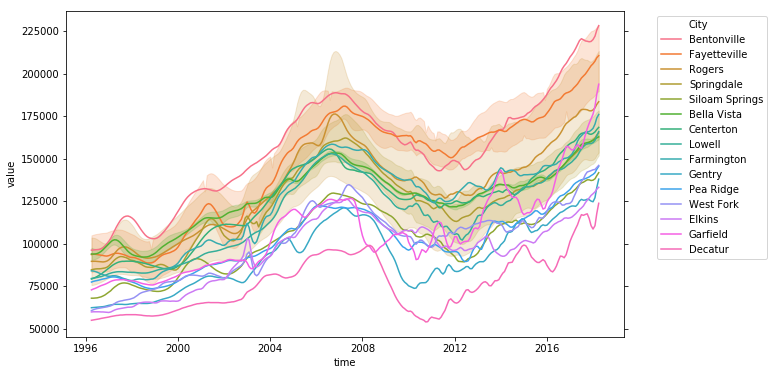

In [202]:
#Plot all the zipcodes from Washington & Benton county
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

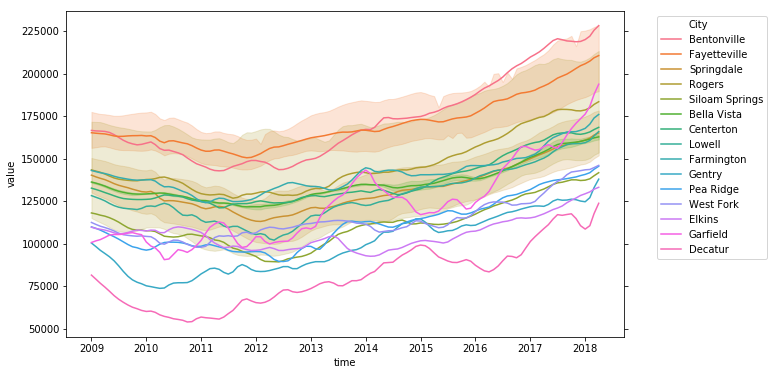

In [203]:
#Plot all the zipcodes with data after 2009
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted2009)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));


In [207]:
#Sort dataframe be increase in value and plot
dfARCountyMelted2009.sort_values(by=['Increase'], ascending=False)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,AvgPrice_2013,AvgPrice_2018,Increase,time,value
5299,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2018-04-01,123800.0
4179,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2013-08-01,75200.0
4999,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2017-01-01,101300.0
4699,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2015-10-01,89700.0
3419,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2010-06-01,56600.0
4139,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2013-06-01,76800.0
4479,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2014-11-01,96400.0
5019,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2017-02-01,104100.0
4119,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2013-05-01,77600.0
4099,89720,72722,Decatur,AR,Fayetteville,Benton,12603,64210.204082,93203.284439,45.153385,2013-04-01,77300.0


In [204]:
#Create dataset by county
WashingtonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Washington']
BentonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Benton']

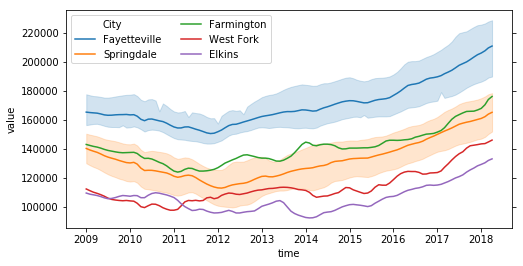

In [205]:
#Washington county plot
plt.figure(figsize=(8, 4))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=WashingtonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=2);

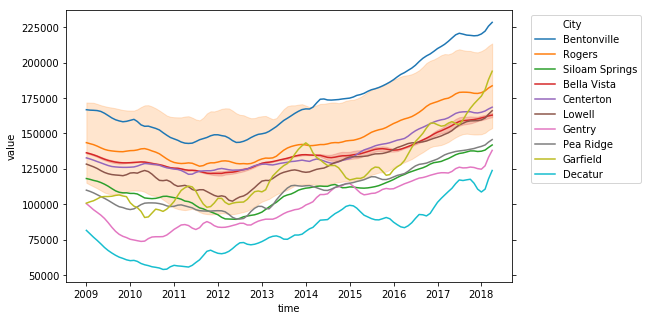

In [206]:
#Benton county plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=BentonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1.03, 1));

# Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results